This demo shows benefits of recalibrating the probabilistic model for predicting propensity score in the estimation of treatment effects. 

In [1]:
# Adapted from https://florianwilhelm.info/2017/04/causal_inference_propensity_score/

from math import exp, log

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.special import expit

import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%matplotlib inline 


import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

np.seterr(divide='ignore', invalid='ignore')
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


We generate a simulated dataset for the purpose of this demo. 

We simulate 3 covariates for an individual - sex, age and the severity of disease. If the individual consumes the medication, then they belong to the treated group, otherwise they belong to the control group. Thus, treatment is binary. The outcome is recovery time of the patient as is simulated using covariates and treatment value. 

In [2]:
MULTIPLICITY = 1

# Simulate outcome as patient recovery time
def exp_recovery_time(*args):
    
    sex = args[0][0]
    age = args[0][MULTIPLICITY]
    severity = args[0][MULTIPLICITY*2]
    medication = args[0][MULTIPLICITY*3]
    
    return exp(2+0.5*sex+0.03*age+2*severity-1*medication)


def rvs_recovery_time(*args):
    return stats.poisson.rvs(exp_recovery_time(args))

# Simulate treatment as whether the patient receives the medicine. 
# Here, the medicine is given to the patient depending on the age group and severity of disease

# Following is Simulation A, and remaining simulations in the paper follow in the commented lines
def get_medication(*args):
    sex = args[0]
    age = args[MULTIPLICITY]
    severity = args[MULTIPLICITY*2]
    if(args[0]==1):        
        return int(age > 45)
    else:
        return int(severity > 0.3)
    
    
# # Simulation B

# def get_medication(*args):
#     sex = args[0]
#     age = args[MULTIPLICITY]
#     severity = args[MULTIPLICITY*2]
#     if(args[0]==1):
#         return int(severity > 0.3)
#     else:
#         return int(age > 40)
        

# # Simulation C

# def get_medication(*args):
#     sex = args[0]
#     age = args[MULTIPLICITY]
#     severity = args[MULTIPLICITY*2]
#     return int(age > 50 or severity>0.7)

# # Simulation D
# def get_medication(*args):
#     sex = args[0]
#     age = args[MULTIPLICITY]
#     severity = args[MULTIPLICITY*2]
#     return int((age > 50) != (severity>0.7))
    


    
    


We evaluate the calibration of probabilistic model for propensity scores using the following metric: the expected calibration error. Lower error indicates improved calibration. 

In [3]:
# Expected calibration error of the probabilistic propensity score model
def ece(y_true, y_pred, n_bins=10):
    x_axis = np.arange(0, 1.1, (1.0)/n_bins)
    y_axis = np.zeros(x_axis.shape)
    N = len(y_true)
    score = 0
    for i, x in enumerate(x_axis):
        if(i==0):
            continue
        bin_outputs = y_true[np.logical_and(y_pred<=x, y_pred>x_axis[i-1])]
        bin_preds = y_pred[np.logical_and(y_pred<=x, y_pred>x_axis[i-1])]
        
            
        if(len(bin_outputs)>0):
            y_axis[i]=bin_outputs.mean()
            avg_pred = bin_preds.mean()
        else:
            y_axis[i]=0
            avg_pred = 0
        
        score+=abs(y_axis[i]-avg_pred)*((1.0*len(bin_outputs))/N)
  
    return score

The simulation setup is as follows - 

In [4]:

# Number of individuals 
N = 10000 

# Create a test dataset (to evaluate metrics like calibration error)

# simulate the covariates sex, age and severity of disease
sexes = [np.random.randint(0, 2, size=1000) ]  # sex == 1 if male otherwise female
    
ages_dist = stats.gamma(8, scale=4)
ages = [ages_dist.rvs(size=1000)]

sev_dist = stats.beta(3, 1.5)
severties = [sev_dist.rvs(size=1000)]


features = ['sex'] + ['age'] + ['severity'] 

# Assign to pandas dataframe
df_test = pd.DataFrame(np.array((sexes + ages + severties)).T, columns=features)

# simulate the treatment using our treatment assignment function, thus creating an observational dataset
df_test['medication'] = df_test.apply(lambda x: get_medication(*x), axis=1)
# simulate recovery times
df_test['recovery'] = df_test.apply(lambda x: rvs_recovery_time(*x) , axis=1)
print(df_test)

# Extract feature values from test dataset for ease of downstream processing
X_test = df_test[features+['medication']].values
X_neg_test = np.copy(X_test)
X_neg_test[:, df_test.columns.get_loc('medication')] = 0 # set the medication column to 0
X_pos_test = np.copy(X_test)
X_pos_test[:, df_test.columns.get_loc('medication')] = 1 # set the medication column to 1
X_test = df_test[features].values




     sex        age  severity  medication  recovery
0    0.0  34.609650  0.842100           1        51
1    1.0  56.492904  0.369846           1        54
2    0.0  21.753676  0.742429           1        24
3    0.0  36.443932  0.105518           0        18
4    0.0  18.245322  0.513503           1        12
..   ...        ...       ...         ...       ...
995  0.0  36.522304  0.473311           1        17
996  0.0  45.106940  0.579893           1        27
997  1.0  22.534144  0.534568           0        66
998  1.0  18.740621  0.437190           0        50
999  0.0  42.953159  0.286896           0        47

[1000 rows x 5 columns]


Create a simulated RCT dataset to estimate the true treatment effects directly

In [5]:
# Create simulated RCT to evaluate true treatment effect
sexes = [np.random.randint(0, 2, size=N)]  # sex == 1 if male otherwise female

ages_dist = stats.gamma(8, scale=4)
ages = [ages_dist.rvs(size=N)]

sev_dist = stats.beta(3, 1.5)
severties = [sev_dist.rvs(size=N)]

# randomly assigned treatments
meds = np.random.randint(0, 2, size=N)

features = ['sex'] + ['age'] + ['severity'] + ['medication'] 

# Assign to pandas dataframe
df_rnd = pd.DataFrame(np.array((sexes + ages + severties+[meds])).T, columns=features)
df_rnd['recovery'] = df_rnd.apply(lambda x: rvs_recovery_time(*x) , axis=1)


Use random forest to model outcomes and use this model to estimate treatment effects on the RCT.

Another way to estimate this effect is via the difference in means of treated and control populations.

In [6]:

res = RandomForestRegressor()
X = df_rnd[features].values
y = df_rnd['recovery'].values
res.fit(X, y)

X_neg = np.copy(X)
X_neg[:, df_rnd.columns.get_loc('medication')] = 0 # set the medication column to 0
X_pos = np.copy(X)
X_pos[:, df_rnd.columns.get_loc('medication')] = 1 # set the medication column to 1


# Estimate treatment effect as a ratio
preds_rnd = res.predict(X_pos) / res.predict(X_neg)
true_ate = preds_rnd.mean()
print('True ATE estimate using RCT simulation={0:.4f}'.format(true_ate))


True ATE estimate using RCT simulation=0.3712


Non-randomized, observational datase is created and we compute a naive estimate of treatment effect using outcome regression without any weighing using inverse propensity of treatment. 

In [7]:

df_obs = df_rnd.copy().drop('recovery', axis=1)
# Apply the treatment assignment function
df_obs['medication'] = df_obs.apply(lambda x: get_medication(*x), axis=1)
# simulate outcomes
df_obs['recovery'] = df_obs.apply(lambda x: rvs_recovery_time(*x), axis=1)


# Treatment effect without propensity scores
res = RandomForestRegressor()
X = df_obs[features].values
y = df_obs['recovery'].values
res.fit(X, y)
preds_no_rnd_train = res.predict(X_pos) / res.predict(X_neg)
naive_ate_train = preds_no_rnd_train.mean()
preds_no_rnd_test = res.predict(X_pos_test) / res.predict(X_neg_test)
naive_ate_test = preds_no_rnd_test.mean()

print('True ATE estimate using RCT simulation={0:.4f}'.format(true_ate))
print('Naive ATE estimate using observational train dataset = {0:.04f}'.format(naive_ate_train))
print('Naive ATE estimate using observational test dataset = {0:.04f}'.format(naive_ate_test))



True ATE estimate using RCT simulation=0.3712
Naive ATE estimate using observational train dataset = 0.8603
Naive ATE estimate using observational test dataset = 0.8551


We see that the naive treatment effect estimate above is significantly different from the one we obtained using RCT simulation. Now, we train a propensity score model with and without calibration of the probabilistic outcomes. For this experiment, we use Logistic Regression as the base model since it is a popular as propensity score assignment model. But it is also possible to use other models including Naive Bayes, Decision Trees, Random Forests, MLPs, etc. 

In [8]:
# Training dataset for propensity score model
X = df_obs[features].drop(['medication'], axis=1).values
y = df_obs['medication'].values # here, y corresponds to treatment and not outcome
# Standardize inputs
scaler = StandardScaler()
scaler.fit(X)
X_train_transf = scaler.transform(X)

X_test_transf = scaler.transform(X_test)
y_test = df_test['medication'].values # here, y corresponds to treatment and not outcome
# Standardize inputs

# Plain propensity score model (uncalibrated)
cls_uncalib = LogisticRegression()
cls_uncalib.fit(X_train_transf, y)

# Calibrated propensity score model
cls_calib = LogisticRegression()
# isotonic regression used to train recalibrator and cross-val splits to generate calibration dataset 
cls_calib = CalibratedClassifierCV(cls_calib, method='isotonic', ensemble=True, cv=10) 
cls_calib.fit(X_train_transf, y)

CalibratedClassifierCV(cv=10, estimator=LogisticRegression(), method='isotonic')

Now, we can use the models to predict the propensities and save to respective dataframes

In [9]:
 
# Train
propensity_calib_train = pd.DataFrame(cls_calib.predict_proba(X_train_transf))
propensity_uncalib_train = pd.DataFrame(cls_uncalib.predict_proba(X_train_transf))

# Test
propensity_calib_test = pd.DataFrame(cls_calib.predict_proba(X_test_transf))
propensity_uncalib_test = pd.DataFrame(cls_uncalib.predict_proba(X_test_transf))



We can evaluate whether the calibration of propensity model improves after applying recalibration by computing an expected calibration error (ECE). Lower ECE implies better calibration. We also plot a histogram of propensity scores before and after applying calibration

In [10]:


########################

# Compute calibration error on the test dataset

# After calibration

y_true = y_test
y_pred = cls_calib.predict_proba(X_test_transf)[:,1]
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)

ece_calib = ece(y_true, y_pred, n_bins=10)

# Before calibration
y_true = y_test
y_pred = cls_uncalib.predict_proba(X_test_transf)[:,1]
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
ece_uncalib = ece(y_true, y_pred, n_bins=10)

print("Calibration score before applying recalibration={0:.4f}".format(ece_uncalib))
print("Calibration score after applying recalibration={0:.4f}".format(ece_calib))



Calibration score before applying recalibration=0.0235
Calibration score after applying recalibration=0.0126


Now we compute inverse propensity scores and weight the training data using them to estimate treatment effects.

In [13]:

# Add calibrated and uncalibrated propensity scores to the dataframe
df_obs['iptw'] = np.clip(1. / (df_obs['medication']*propensity_calib_train[1] + (1-df_obs['medication'])*propensity_calib_train[0]), a_min = 0.001, a_max = 1000)
df_obs['iptw_uncalib'] = np.clip(1. / (df_obs['medication']*propensity_uncalib_train[1] + (1-df_obs['medication'])*propensity_uncalib_train[0]), a_min = 0.001, a_max = 1000)

df_test['iptw'] = np.clip(1. / (df_test['medication']*propensity_calib_test[1] + (1-df_test['medication'])*propensity_calib_test[0]), a_min = 0.001, a_max = 1000)
df_test['iptw_uncalib'] = np.clip(1. / (df_test['medication']*propensity_uncalib_test[1] + (1-df_test['medication'])*propensity_uncalib_test[0]), a_min = 0.001, a_max = 1000)

# Inverse propensity score weighting and final estimation using random forest to estimate outcome
reg = RandomForestRegressor(random_state=42)

X = df_obs[features].values
y = df_obs['recovery'].values
reg.fit(X, y, sample_weight=df_obs['iptw'].values)

reg_uncalib = RandomForestRegressor(random_state=42)
reg_uncalib.fit(X, y, sample_weight=df_obs['iptw_uncalib'].values)

preds_propensity_calib_train = reg.predict(X_pos) / reg.predict(X_neg)
preds_propensity_uncalib_train = reg_uncalib.predict(X_pos) / reg_uncalib.predict(X_neg)

preds_propensity_calib_test = reg.predict(X_pos_test) / reg.predict(X_neg_test)
preds_propensity_uncalib_test = reg_uncalib.predict(X_pos_test) / reg_uncalib.predict(X_neg_test)






In [14]:
# Compute average treatment effect using inverse propensity weighting, with and without calibration
print('True ATE estimate using RCT simulation={0:.4f}'.format(true_ate))
print('ATE estimate using inverse of calibrated propensity weights [Train]={0:.4f})'.format(preds_propensity_calib_train.mean()))
print('ATE estimate using inverse of plain propensity weights [Train]={0:.4f})'
.format(preds_propensity_uncalib_train.mean()))
print('ATE estimate using inverse of calibrated propensity weights [Test]={0:.4f})'
.format(preds_propensity_calib_test.mean()))
print('ATE estimate using inverse of plain propensity weights [Test]={0:.4f})'
.format(preds_propensity_uncalib_test.mean()))


True ATE estimate using RCT simulation=0.3712
ATE estimate using inverse of calibrated propensity weights [Train]=0.4157)
ATE estimate using inverse of plain propensity weights [Train]=0.8401)
ATE estimate using inverse of calibrated propensity weights [Test]=0.4157)
ATE estimate using inverse of plain propensity weights [Test]=0.8348)


We see that the ATE estimate with calibrated propensity weights is closest to the ATE estimate computed via RCT. We can now compare the distribution of treatment effect (ratio) under different setups. We see that the calibrated propensity scores yield a distribution much closer to the true distribution of treatment effects

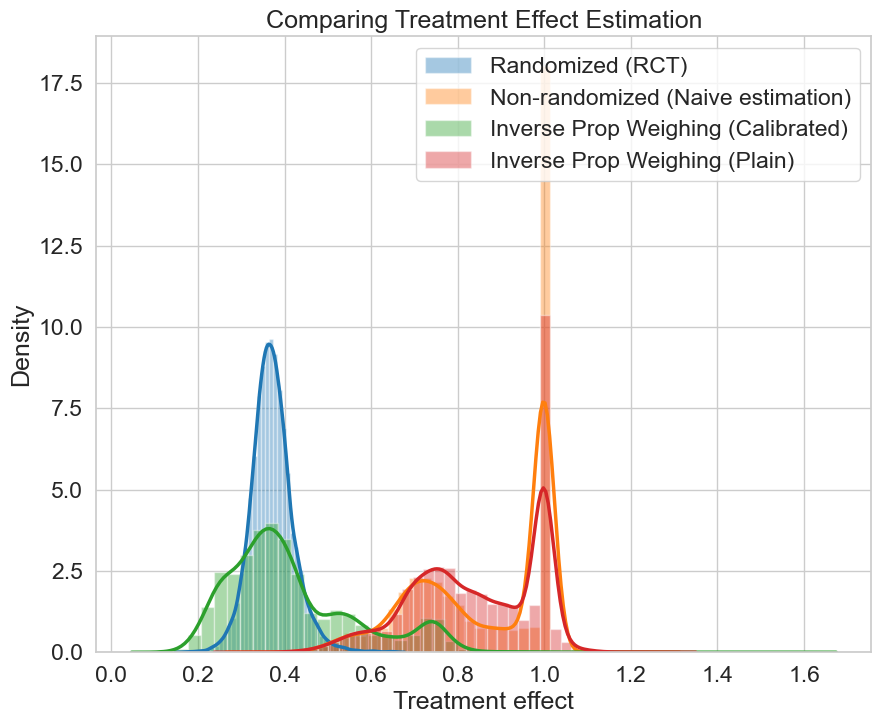

In [15]:

sns.distplot(preds_rnd, label='Randomized (RCT)')
sns.distplot(preds_no_rnd_train, label='Non-randomized (Naive estimation)')
ax = sns.distplot(preds_propensity_calib_train, label='Inverse Prop Weighing (Calibrated)')
ax = sns.distplot(preds_propensity_uncalib_train, label='Inverse Prop Weighing (Plain)')
ax.set_xlabel('Treatment effect')
ax.set_ylabel('Density')
plt.title("Comparing Treatment Effect Estimation")
plt.legend();


Following is the complete experiment repeated 10 times and the metrics of interest are produced in the end. We see that calibrated propensities produce improved ATE estimates on an average. 

----------------------------------------------------------------------------
Experiment Repetition 0
----------------------------------------------------------------------------


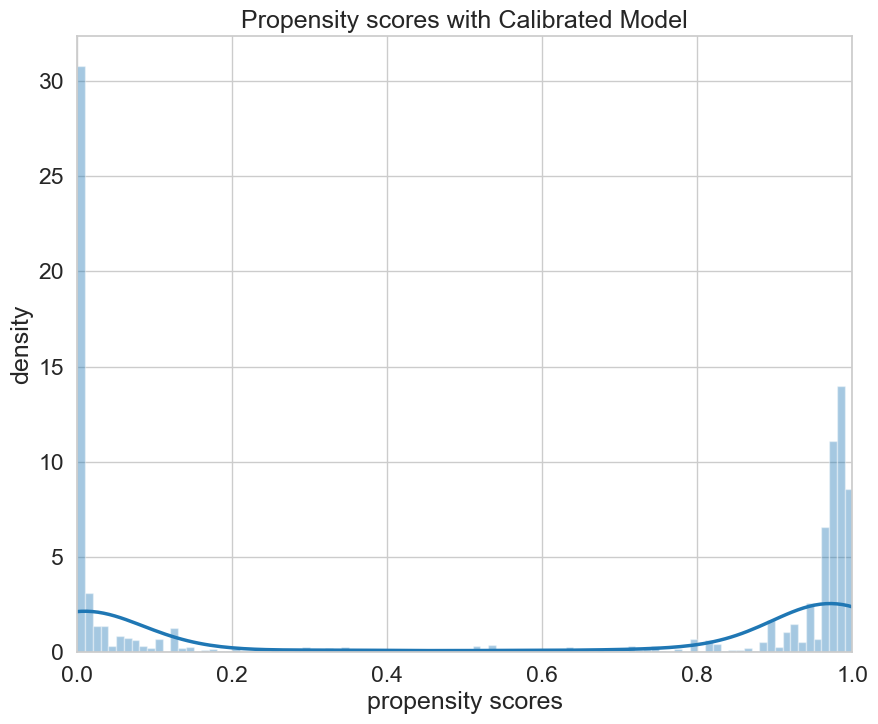

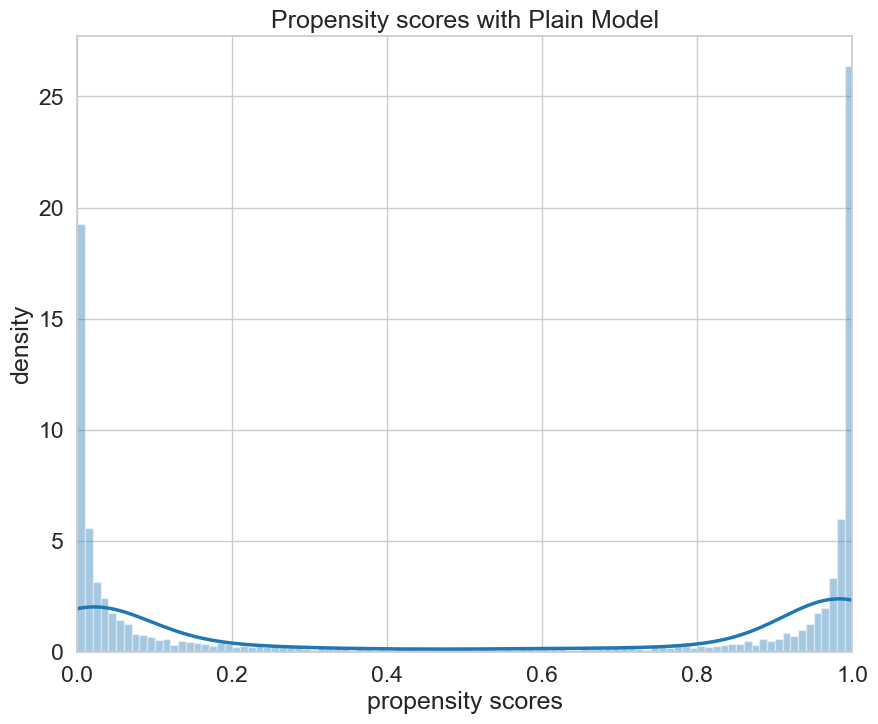

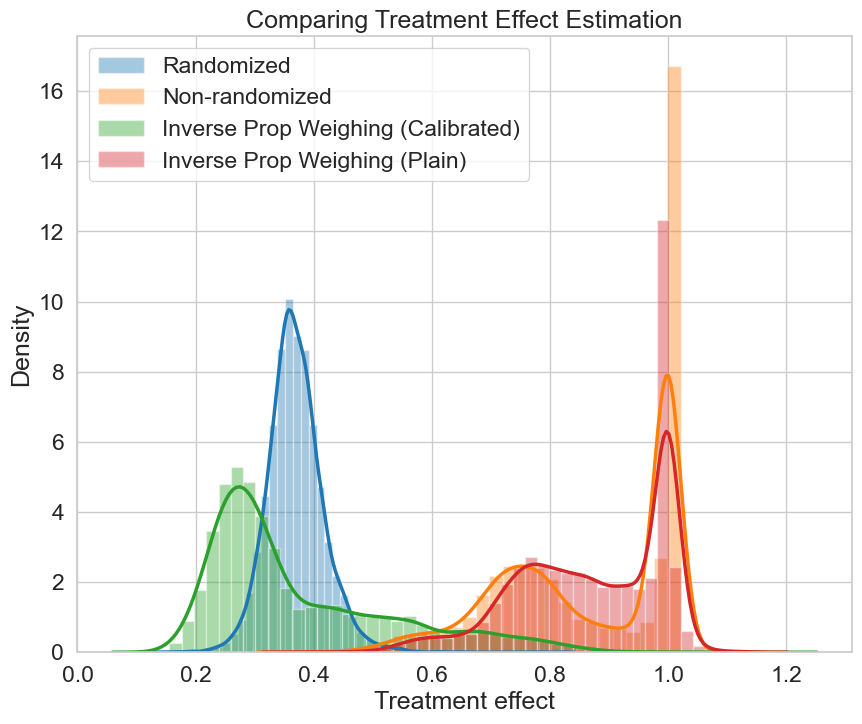

----------------------------------------------------------------------------
Experiment Repetition 1
----------------------------------------------------------------------------


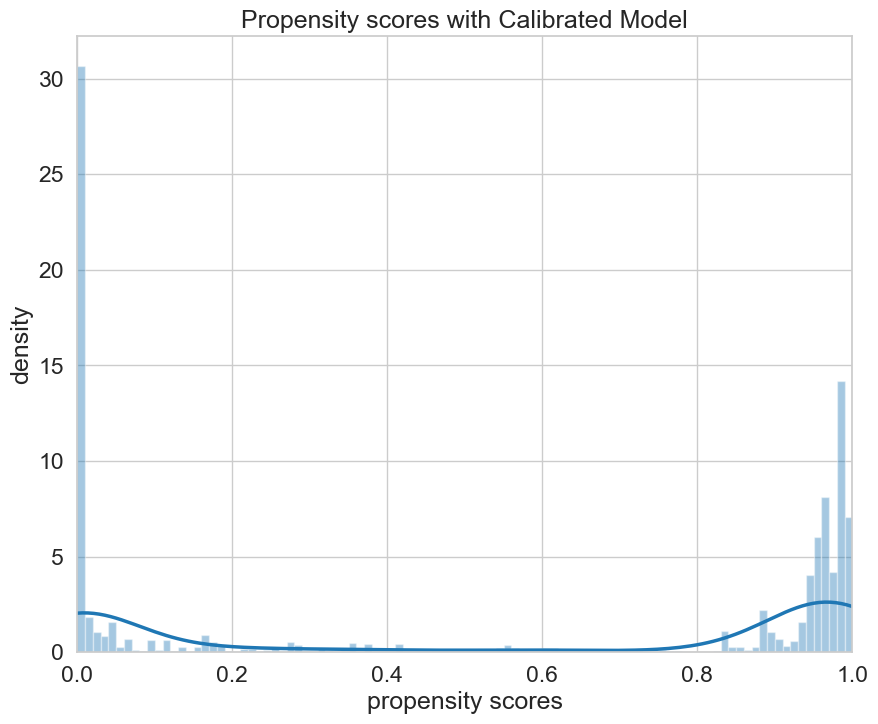

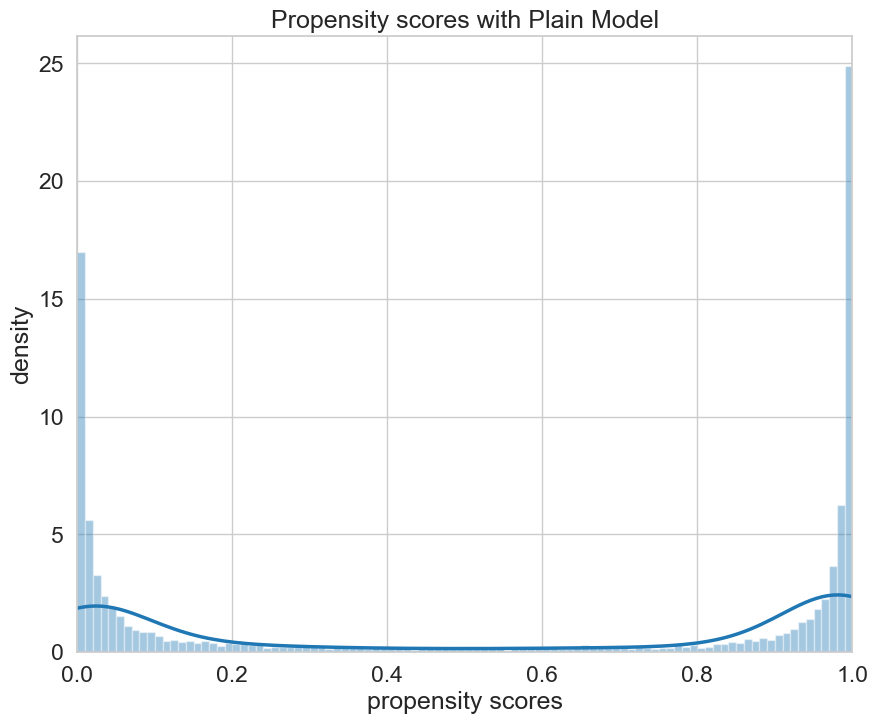

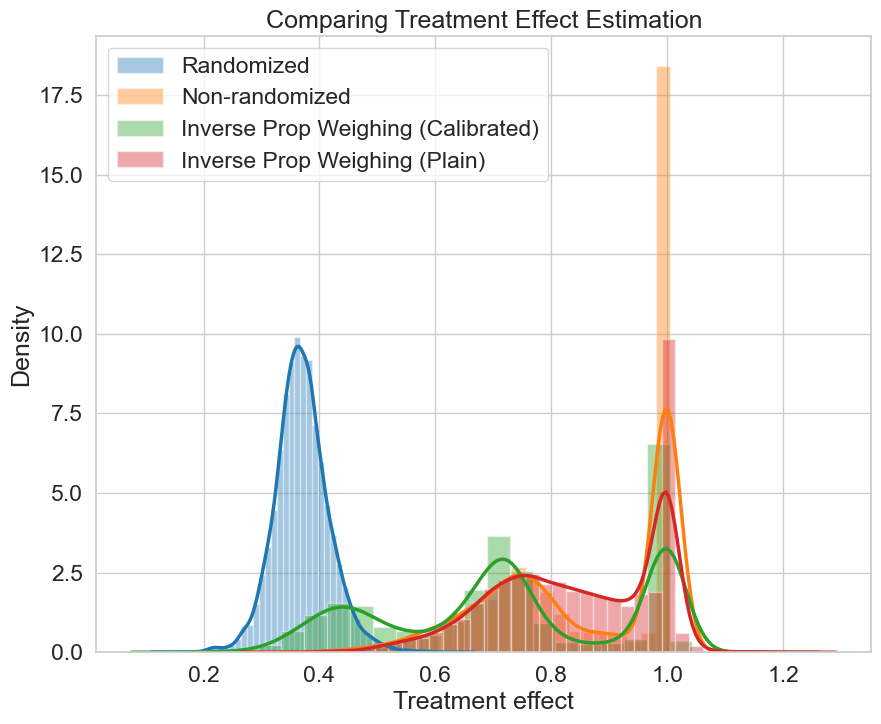

----------------------------------------------------------------------------
Experiment Repetition 2
----------------------------------------------------------------------------


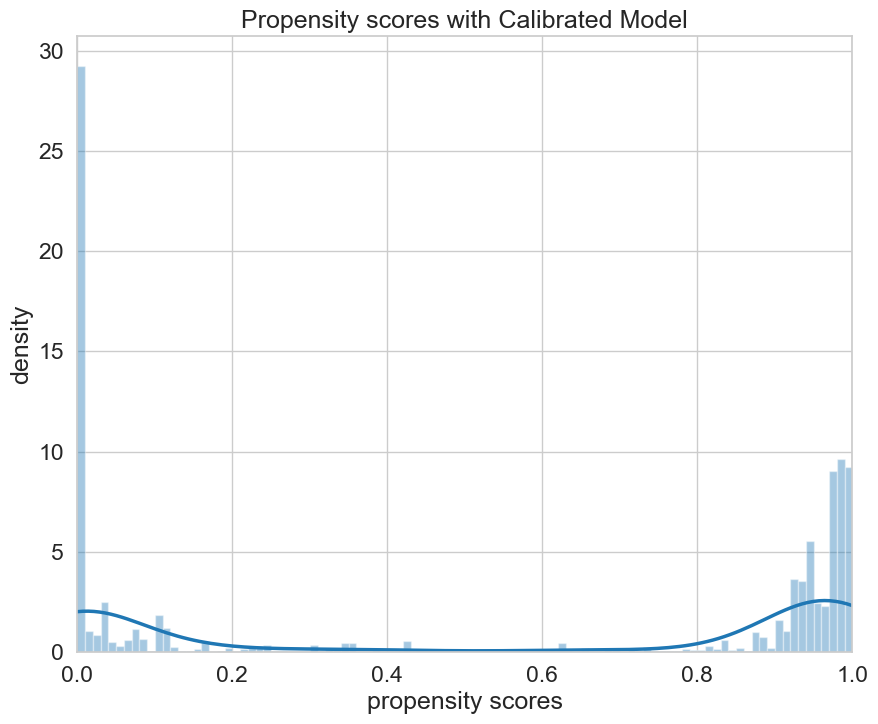

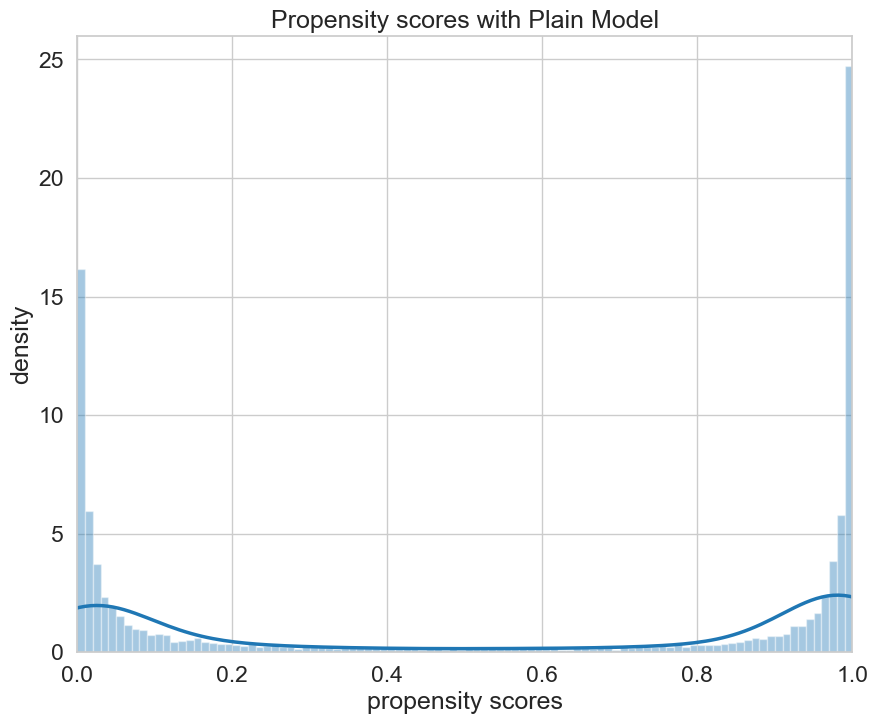

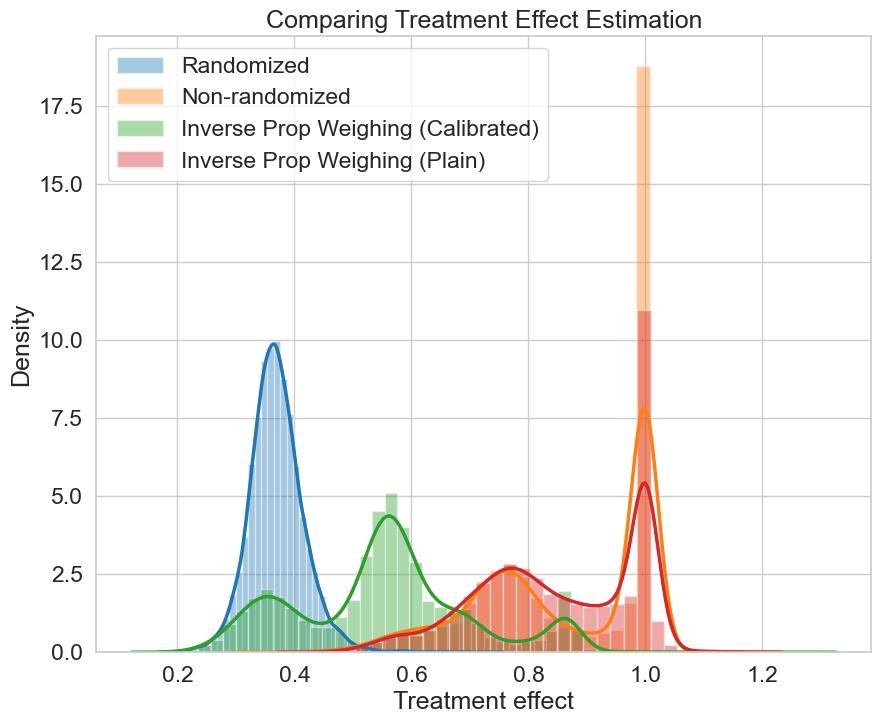

----------------------------------------------------------------------------
Experiment Repetition 3
----------------------------------------------------------------------------


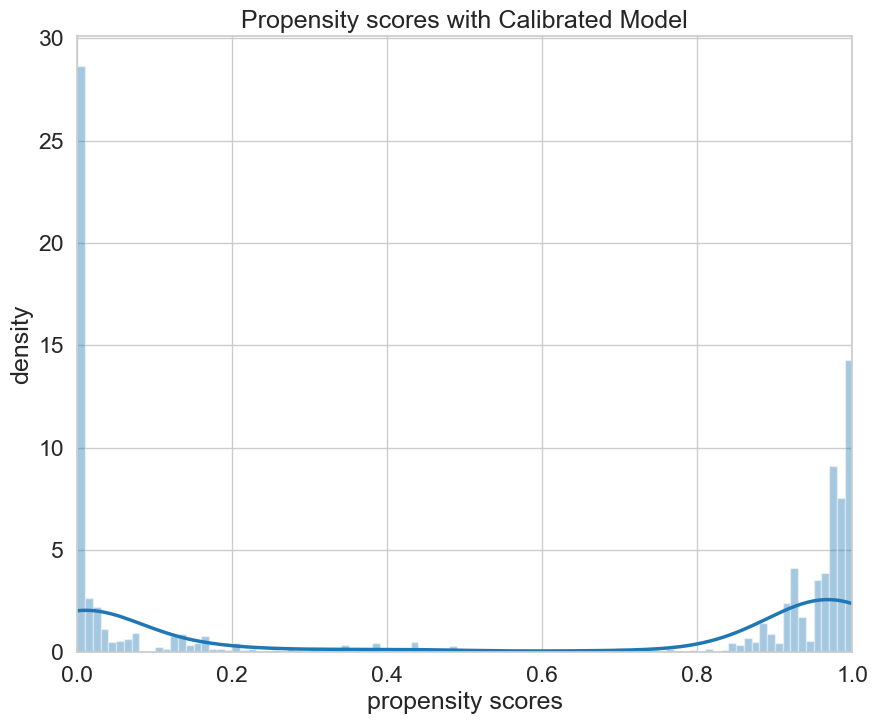

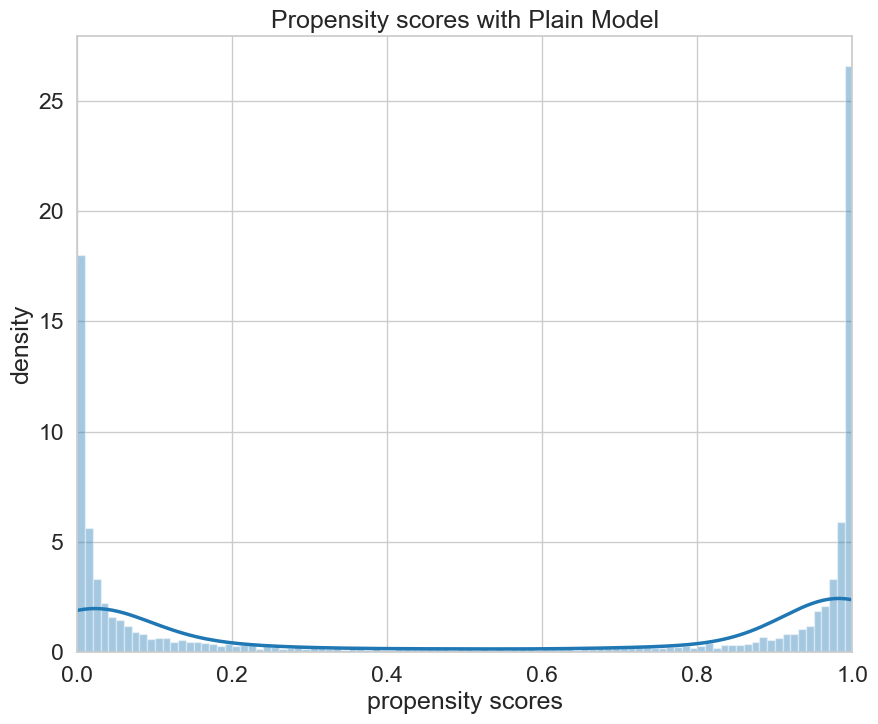

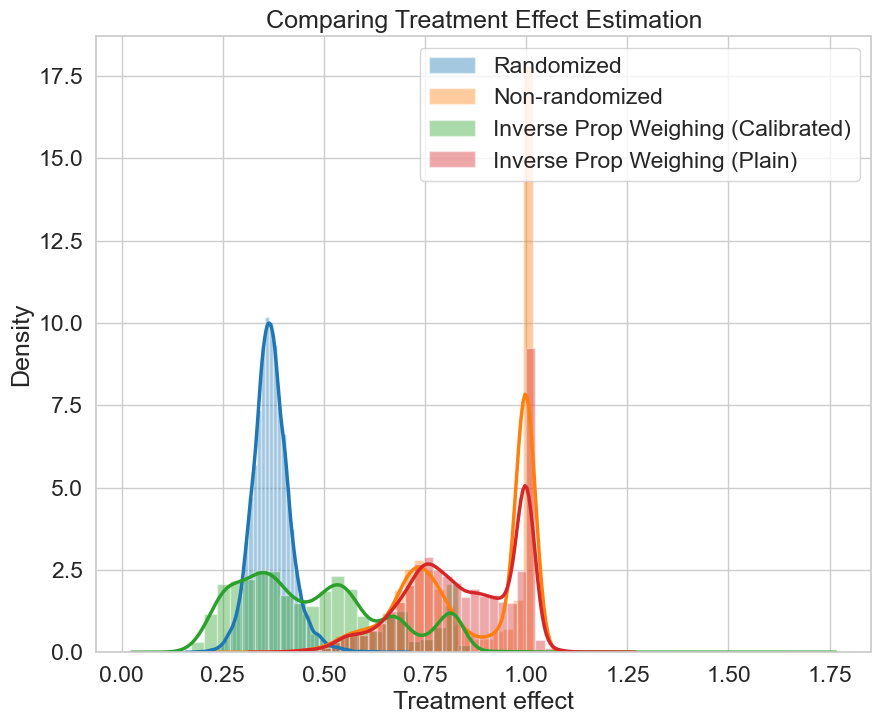

----------------------------------------------------------------------------
Experiment Repetition 4
----------------------------------------------------------------------------


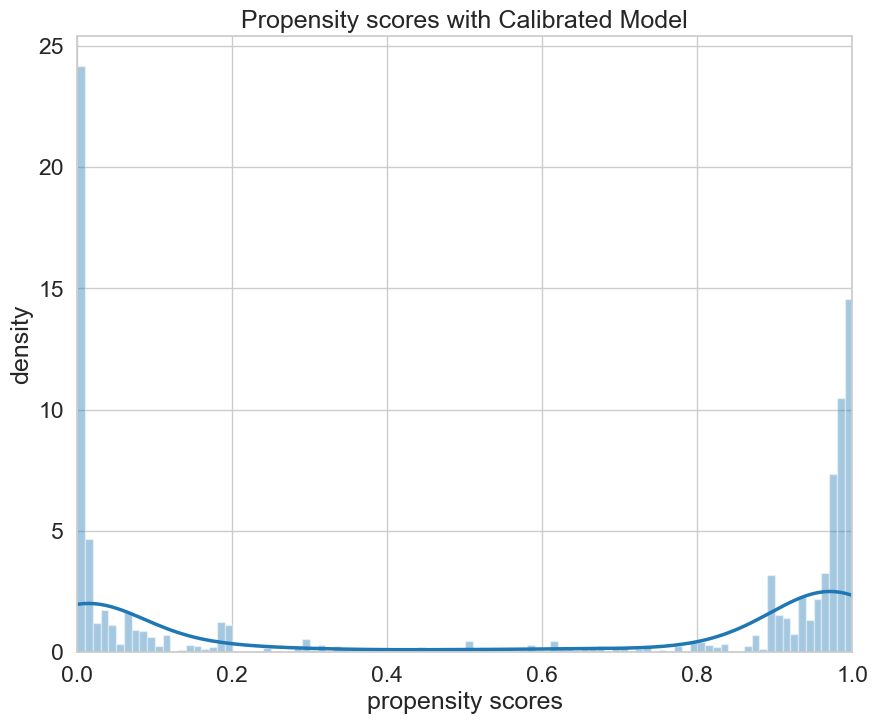

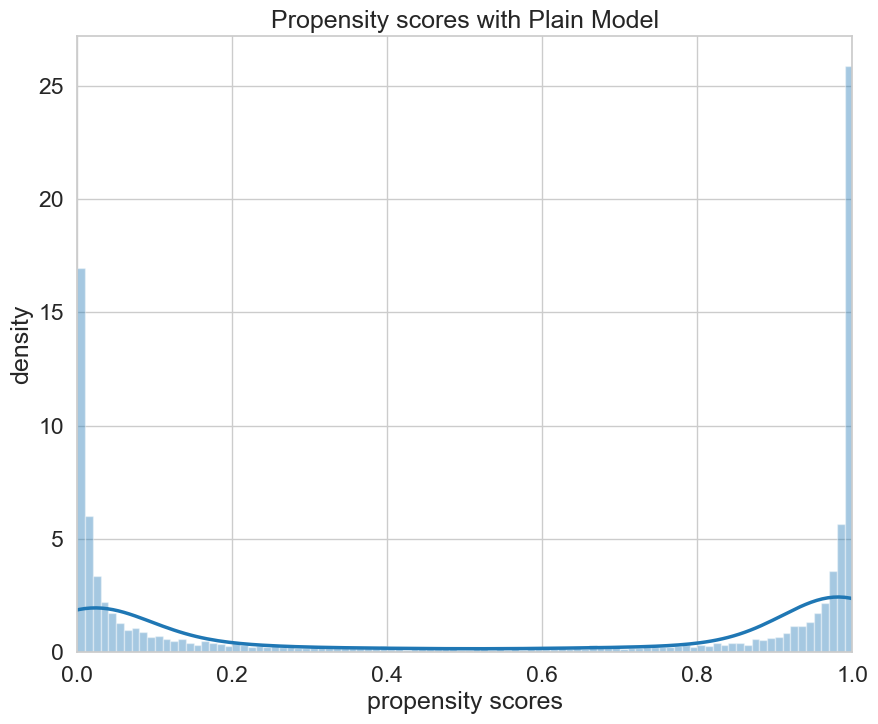

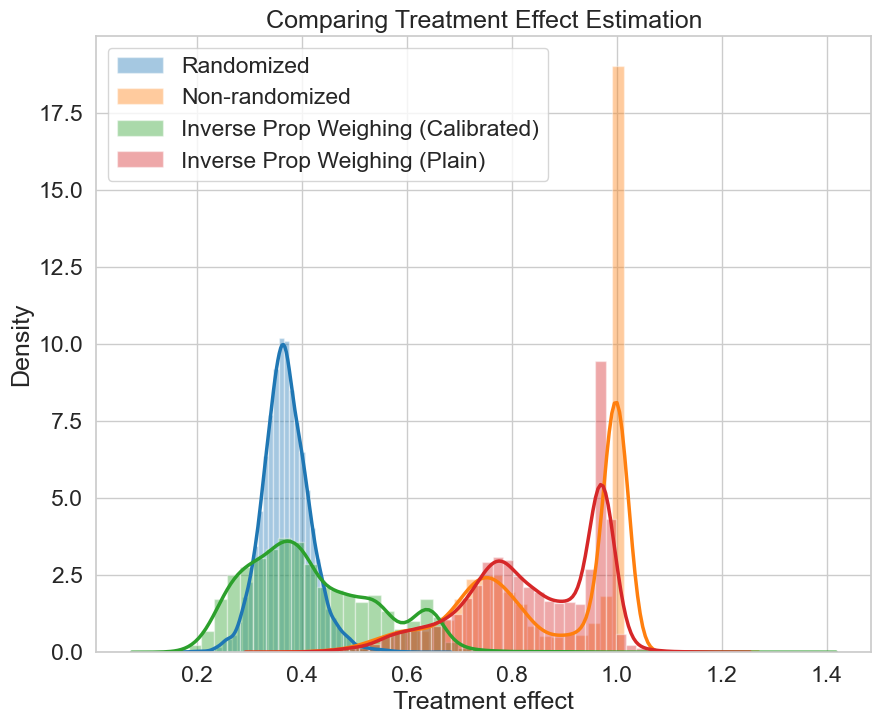

----------------------------------------------------------------------------
Experiment Repetition 5
----------------------------------------------------------------------------


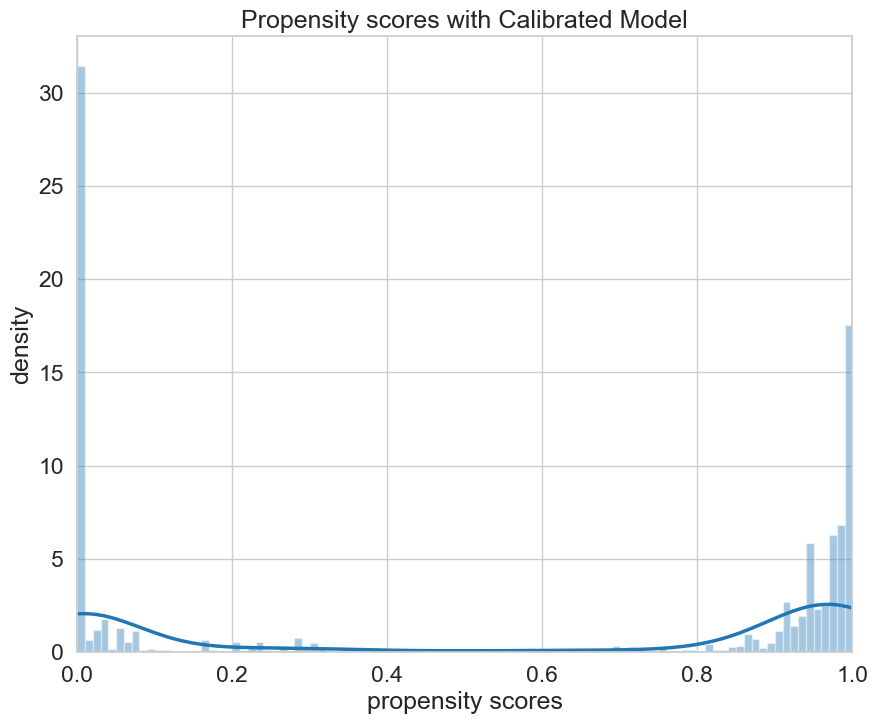

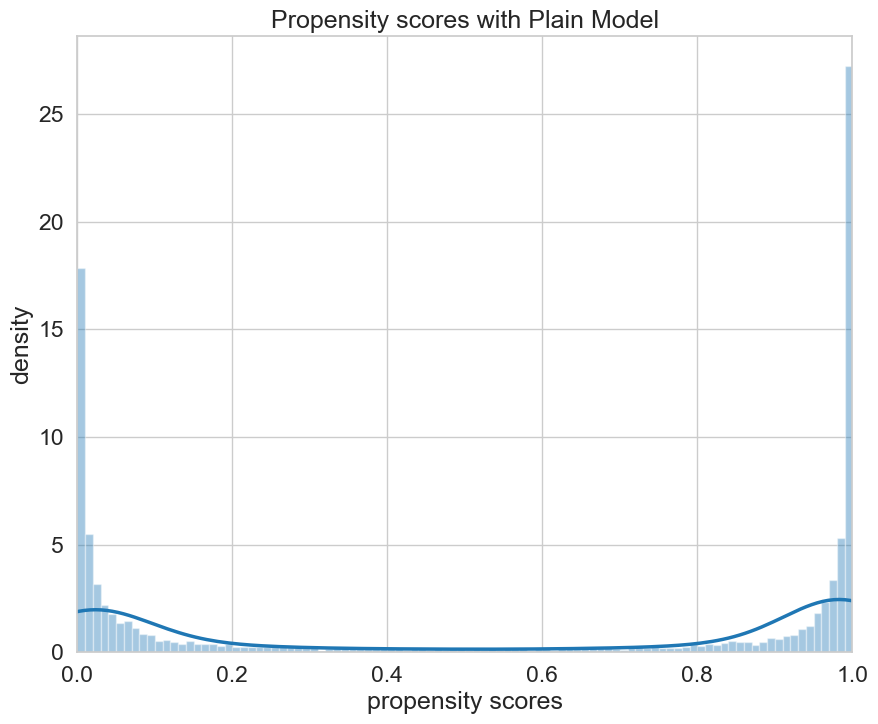

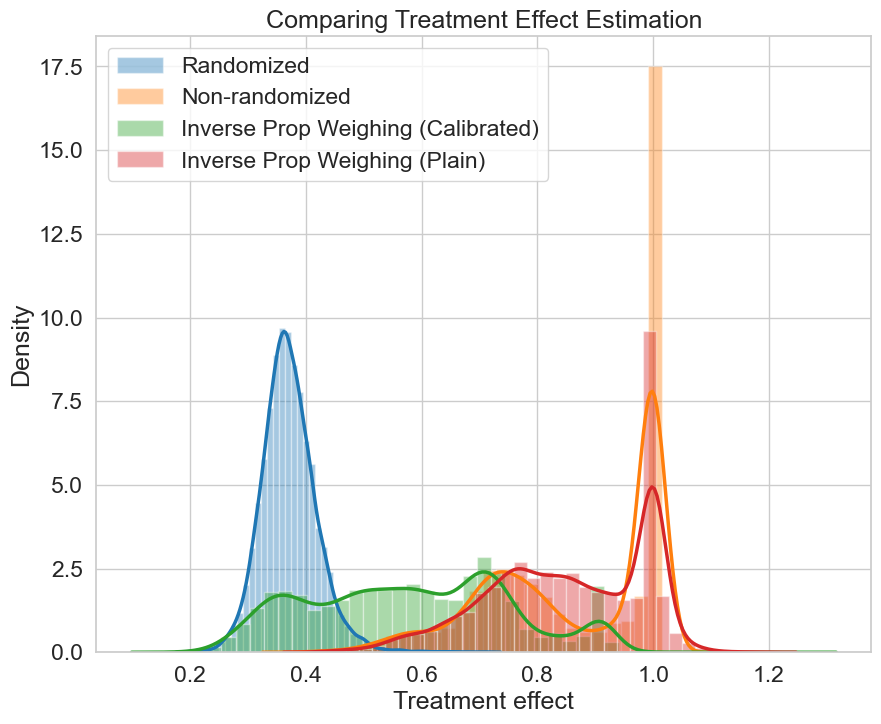

----------------------------------------------------------------------------
Experiment Repetition 6
----------------------------------------------------------------------------


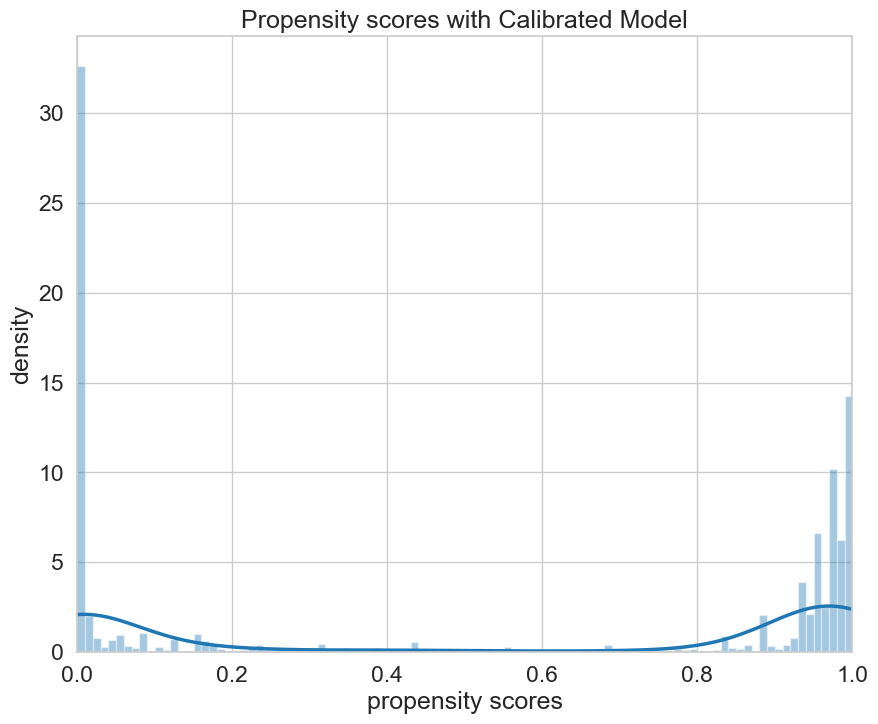

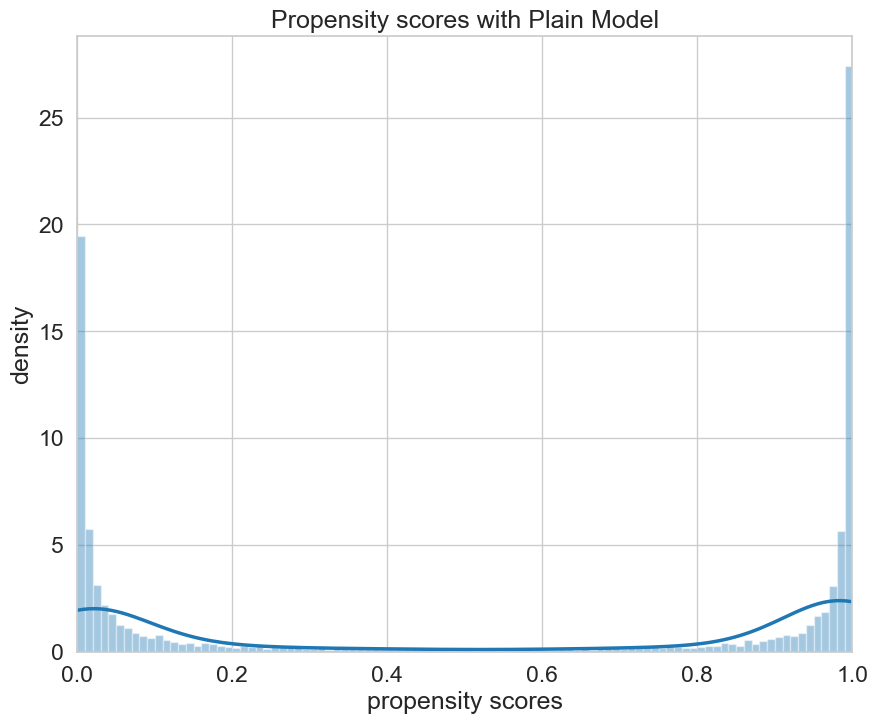

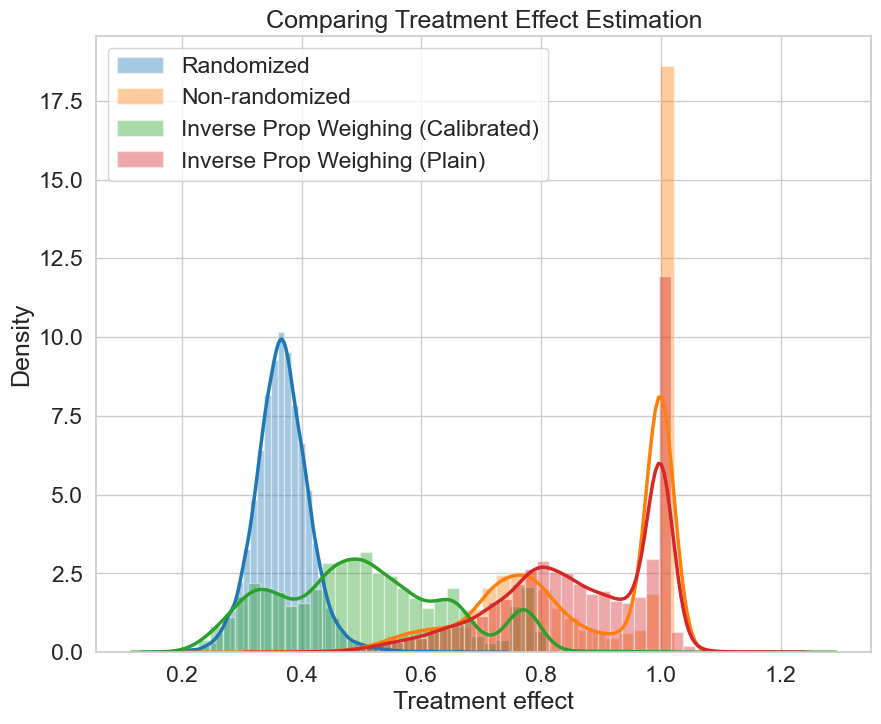

----------------------------------------------------------------------------
Experiment Repetition 7
----------------------------------------------------------------------------


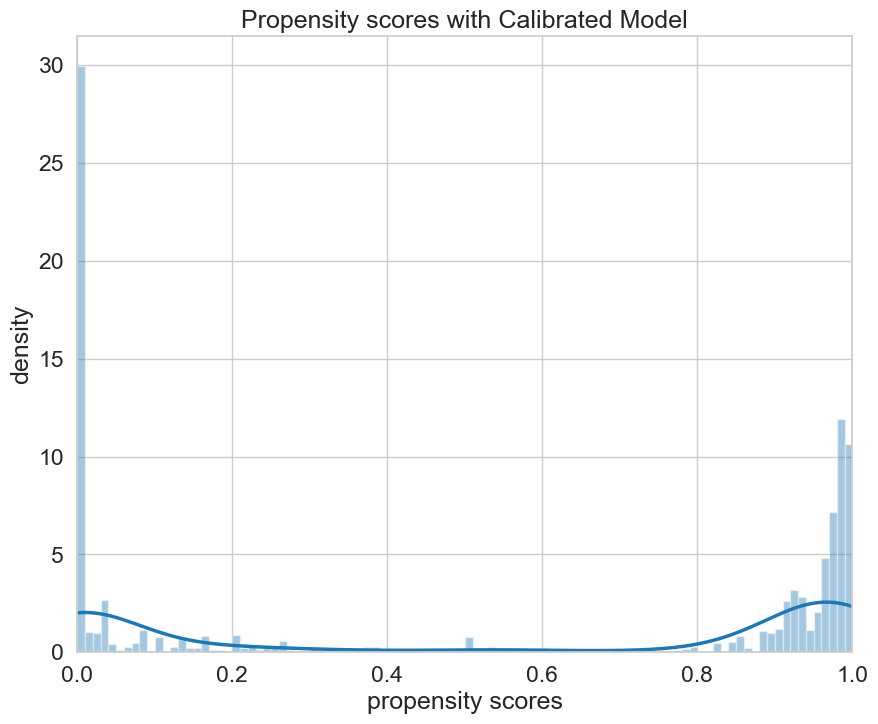

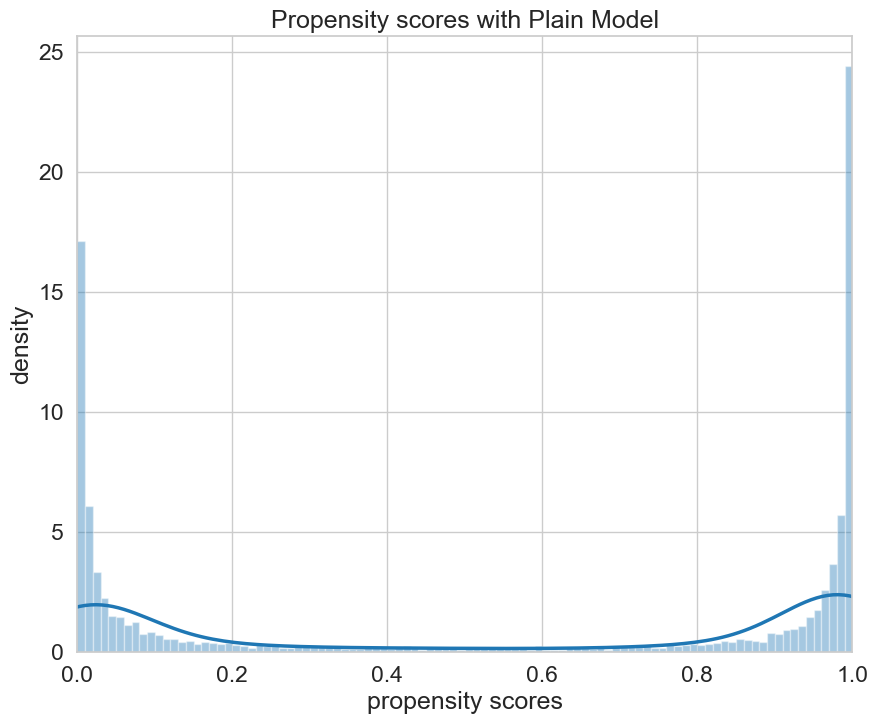

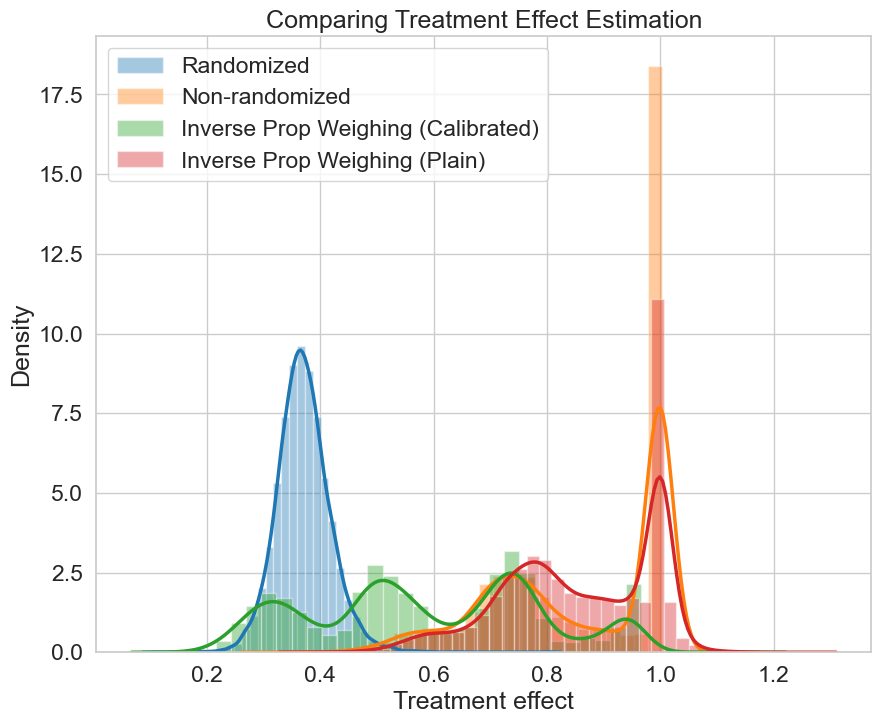

----------------------------------------------------------------------------
Experiment Repetition 8
----------------------------------------------------------------------------


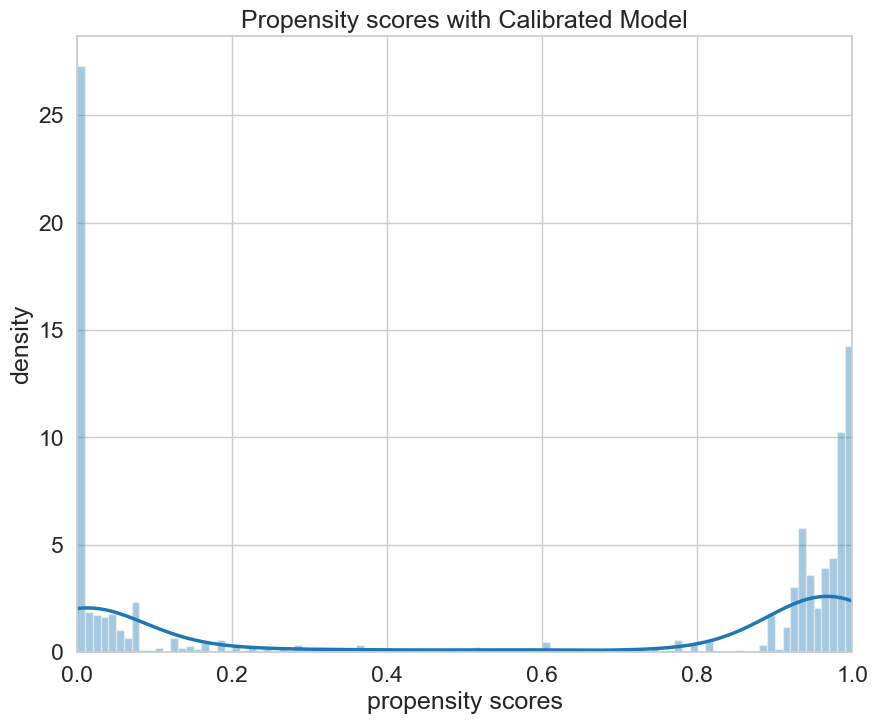

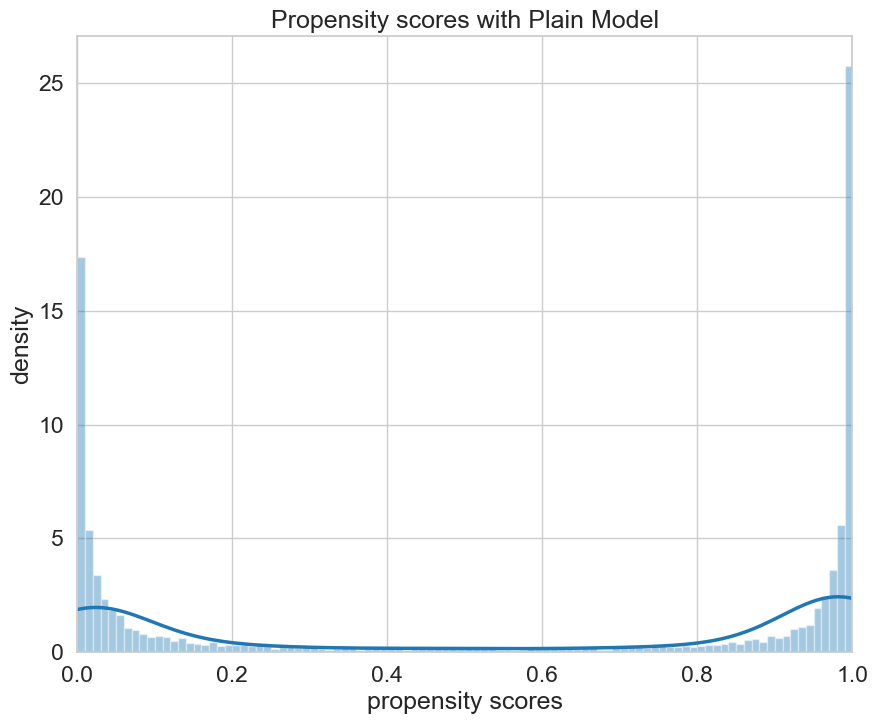

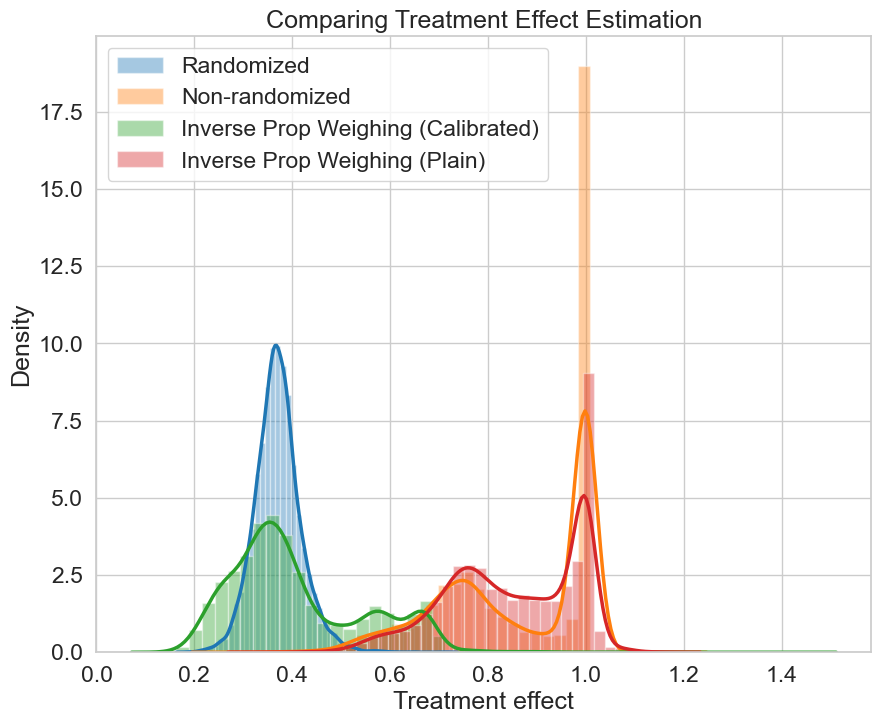

----------------------------------------------------------------------------
Experiment Repetition 9
----------------------------------------------------------------------------


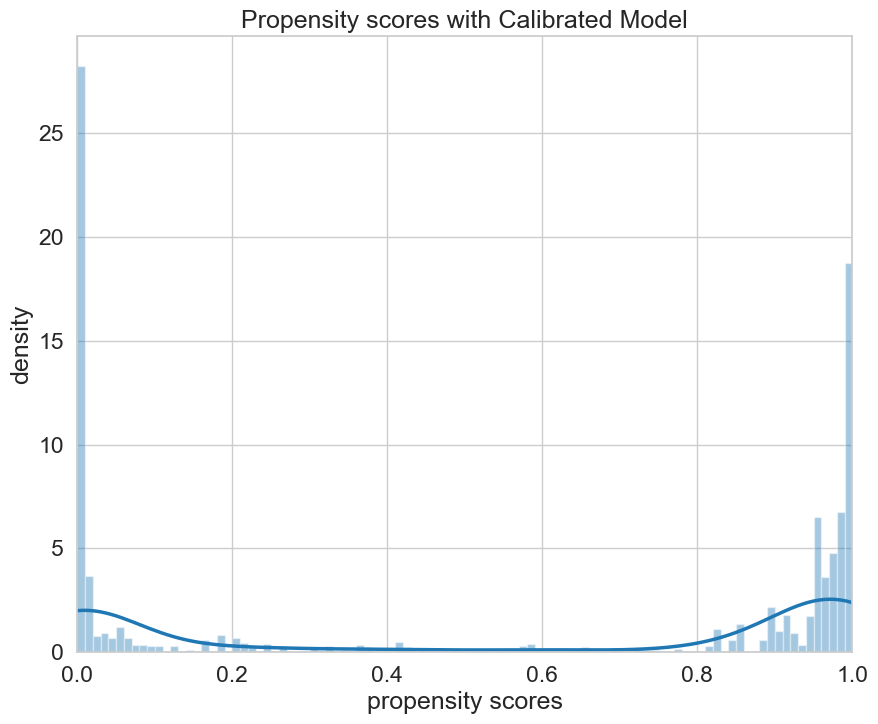

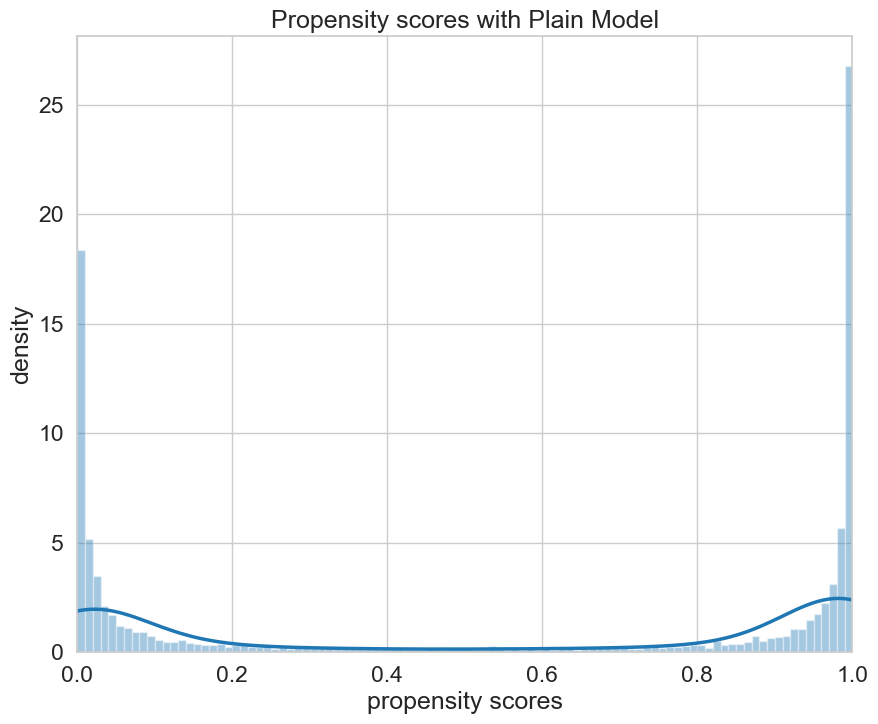

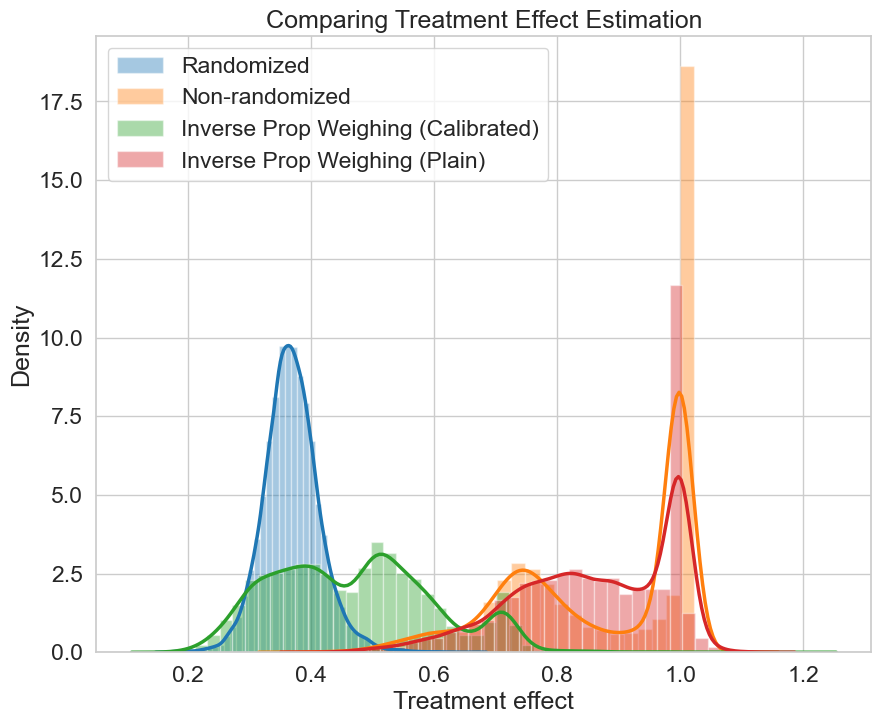

In [16]:
# Simulation setup

# Number of individuals 
N = 10000  

# Experiment repetition
EXP_REPS = 10


# All results collected here
results = np.zeros((EXP_REPS, 9))


# Test dataset to evaluate the calibration error
sexes = [np.random.randint(0, 2, size=1000) for x in range(MULTIPLICITY)]  # sex == 1 if male otherwise female
    
ages_dist = [stats.gamma(8, scale=4) for x in range(MULTIPLICITY)]
ages = [ages_dist[x].rvs(size=1000) for x in range(MULTIPLICITY)]

sev_dist = [stats.beta(3, 1.5) for x in range(MULTIPLICITY)]
severties = [sev_dist[x].rvs(size=1000) for x in range(MULTIPLICITY)]
meds = np.random.randint(0, 2, size=1000)


features = ['sex'+str(i) for i in range(MULTIPLICITY)] + ['age'+str(i) for i in range(MULTIPLICITY)] + ['severity'+str(i) for i in range(MULTIPLICITY)] + ['medication'] 

# Assign to pandas dataframe
df_test = pd.DataFrame(np.array((sexes + ages + severties+[meds])).T, columns=features)
df_test['medication'] = df_test.apply(lambda x: get_medication(*x), axis=1)
df_test['recovery'] = df_test.apply(lambda x: rvs_recovery_time(*x) , axis=1)

X_test = df_test[features].values
X_neg_test = np.copy(X_test)
X_neg_test[:, df_test.columns.get_loc('medication')] = 0 # set the medication column to 0
X_pos_test = np.copy(X_test)
X_pos_test[:, df_test.columns.get_loc('medication')] = 1 # set the medication column to 1
X_test = df_test[features].drop(['medication'], axis=1).values


# Run experiments

for i in range(EXP_REPS):
    
    print("----------------------------------------------------------------------------")
    print("Experiment Repetition "+str(i))
    print("----------------------------------------------------------------------------")
    
    # Create simulated RCT to evaluate true treatment effect
    sexes = [np.random.randint(0, 2, size=N) for x in range(MULTIPLICITY)]  # sex == 1 if male otherwise female
    
    ages_dist = [stats.gamma(8, scale=4) for x in range(MULTIPLICITY)]
    ages = [ages_dist[x].rvs(size=N) for x in range(MULTIPLICITY)]
    
    sev_dist = [stats.beta(3, 1.5) for x in range(MULTIPLICITY)]
    severties = [sev_dist[x].rvs(size=N) for x in range(MULTIPLICITY)]
    
    meds = np.random.randint(0, 2, size=N)
    
    features = ['sex'+str(i) for i in range(MULTIPLICITY)] + ['age'+str(i) for i in range(MULTIPLICITY)] + ['severity'+str(i) for i in range(MULTIPLICITY)] + ['medication'] 

    # Assign to pandas dataframe
    df_rnd = pd.DataFrame(np.array((sexes + ages + severties+[meds])).T, columns=features)
    df_rnd['recovery'] = df_rnd.apply(lambda x: rvs_recovery_time(*x) , axis=1)
    
    
    # Use random forest to model outcomes and use this model to estimate treatment effects on the RCT
    # Another way to estimate this effect is via the difference in means of treated and control populations.
    res = RandomForestRegressor()
    X = df_rnd[features].values
    y = df_rnd['recovery'].values
    res.fit(X, y)
    
    X_neg = np.copy(X)
    X_neg[:, df_rnd.columns.get_loc('medication')] = 0 # set the medication column to 0
    X_pos = np.copy(X)
    X_pos[:, df_rnd.columns.get_loc('medication')] = 1 # set the medication column to 1

    
    # Estimate treatment effect as a ratio
    preds_rnd = res.predict(X_pos) / res.predict(X_neg)
    results[i][0] = preds_rnd.mean()
    
    ########################
    # Non-randomized, observational dataset creation
    ########################

    
    df_obs = df_rnd.copy().drop('recovery', axis=1)
    df_obs['medication'] = df_obs.apply(lambda x: get_medication(*x), axis=1)
    df_obs['recovery'] = df_obs.apply(lambda x: rvs_recovery_time(*x), axis=1)
    
    
    # Treatment effect without propensity scores
    res = RandomForestRegressor()
    X = df_obs[features].values
    y = df_obs['recovery'].values
    res.fit(X, y)
    preds_no_rnd = res.predict(X_pos) / res.predict(X_neg)
    results[i][1] = preds_no_rnd.mean()
    preds_no_rnd_test = res.predict(X_pos_test) / res.predict(X_neg_test)
    results[i][2] = preds_no_rnd_test.mean()
    
    
    # Treatment effect estimation procedure with propensity scores
    X = df_obs[features].drop(['medication'], axis=1).values
    y = df_obs['medication'].values # here, y corresponds to treatment and not outcome
    # Standardize inputs
    scaler = StandardScaler()
    scaler.fit(X)
    X_transf = scaler.transform(X)

    X_test_transf = scaler.transform(X_test)
    y_test = df_test['medication'].values # here, y corresponds to treatment and not outcome
    # Standardize inputs

    # Plain propensity score model (uncalibrated)
    cls_uncalib = LogisticRegression()
    cls_uncalib.fit(X_transf, y)
    
    # Calibrated Propensity Score model
    cls = LogisticRegression()
    cls = CalibratedClassifierCV(cls, method='isotonic', ensemble=True, cv=10) # try this version
    cls.fit(X_transf, y)
    
    
    # Predict the propensities and save to respective dataframes
    # Train
    propensity = pd.DataFrame(cls.predict_proba(X_transf))
    propensity_uncalib = pd.DataFrame(cls_uncalib.predict_proba(X_transf))

    # Test
    propensity_test = pd.DataFrame(cls.predict_proba(X_test_transf))
    propensity_uncalib_test = pd.DataFrame(cls_uncalib.predict_proba(X_test_transf))

    
    
    ########################
    
    # Compute calibration error on the test dataset

    # After calibration
    
    y_true = y_test
    y_pred = cls.predict_proba(X_test_transf)[:,1]
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    
    results[i][3] = ece(y_true, y_pred, n_bins=10)
    
    # Before calibration
    y_true = y_test
    y_pred = cls_uncalib.predict_proba(X_test_transf)[:,1]
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    results[i][4] = ece(y_true, y_pred, n_bins=10)
    
    
    ########################
    
    # Add calibrated and uncalibrated propensity scores to the dataframe
    df_obs['iptw'] = np.clip(1. / (df_obs['medication']*propensity[1] + (1-df_obs['medication'])*propensity[0]), a_min = 0.001, a_max = 1000)
    df_obs['iptw_uncalib'] = np.clip(1. / (df_obs['medication']*propensity_uncalib[1] + (1-df_obs['medication'])*propensity_uncalib[0]), a_min = 0.001, a_max = 1000)

    df_test['iptw'] = np.clip(1. / (df_test['medication']*propensity_test[1] + (1-df_test['medication'])*propensity_test[0]), a_min = 0.001, a_max = 1000)
    df_test['iptw_uncalib'] = np.clip(1. / (df_test['medication']*propensity_uncalib_test[1] + (1-df_test['medication'])*propensity_uncalib_test[0]), a_min = 0.001, a_max = 1000)

    # Propensity score weighting and final estimation
    reg = RandomForestRegressor(random_state=42)

    X = df_obs[features].values
    y = df_obs['recovery'].values
    reg.fit(X, y, sample_weight=df_obs['iptw'].values)

    reg_uncalib = RandomForestRegressor(random_state=42)
    reg_uncalib.fit(X, y, sample_weight=df_obs['iptw_uncalib'].values)

    preds_propensity = reg.predict(X_pos) / reg.predict(X_neg)
    preds_propensity_uncalib = reg_uncalib.predict(X_pos) / reg_uncalib.predict(X_neg)

    preds_propensity_test = reg.predict(X_pos_test) / reg.predict(X_neg_test)
    preds_propensity_uncalib_test = reg_uncalib.predict(X_pos_test) / reg_uncalib.predict(X_neg_test)

    # Compute average treatment effect using inverse propensity weighting, with and without calibration
    results[i][5] = preds_propensity.mean()
    results[i][6] = preds_propensity_uncalib.mean()
    results[i][7] = preds_propensity_test.mean()
    results[i][8] = preds_propensity_uncalib_test.mean()
    
    ########################
    # Figure to compare the distribution of treatment effect (ratio) under different setups
    sns.distplot(preds_rnd, label='Randomized')
    sns.distplot(preds_no_rnd, label='Non-randomized')
    ax = sns.distplot(preds_propensity, label='Inverse Prop Weighing (Calibrated)')
    ax = sns.distplot(preds_propensity_uncalib, label='Inverse Prop Weighing (Plain)')
    ax.set_xlabel('Treatment effect')
    ax.set_ylabel('Density')
    plt.title("Comparing Treatment Effect Estimation")
    plt.legend();
    plt.show()
    ########################
    
    

In [17]:
error_terms = np.concatenate([(results[:,1]-results[:, 0]).reshape(-1, 1), # Naive [Train]
                              (results[:,2]-results[:, 0]).reshape(-1, 1), # Naive [Test]
                              (results[:,5]-results[:, 0]).reshape(-1, 1), # Calib IPW [Train]
                              (results[:,6]-results[:, 0]).reshape(-1, 1), # Plain IPW [Train]
                              (results[:,7]-results[:, 0]).reshape(-1, 1), # Calib IPW [Test]
                              (results[:,8]-results[:, 0]).reshape(-1, 1) ], axis=1) # Plain IPW [Test]


We print error in ATE estimates obtained via our method and compare it against the naive baseline. The figures in round braces are standard errors. We clearly see reduction in error after calibrating the propensity score model.

In [18]:
mean_metrics = error_terms.mean(axis=0)
sem_metrics = error_terms.std(axis=0)/np.sqrt(EXP_REPS)

print("------------------------------------------")
print("Train+val dataset metrics")
print("------------------------------------------")
print('Error in ATE estimate using Outcome regression baseline = {0:.4f} (+/- {1:.4f})'.format(
    mean_metrics[0], sem_metrics[0]))
print('Error in ATE estimate using plain IPTW = {0:.4f} (+/- {1:.4f})'.format(
    mean_metrics[3], sem_metrics[3]))
print('Error in ATE estimate using calibrated IPTW = {0:.4f} (+/- {1:.4f})'.format(
    mean_metrics[2], sem_metrics[2]))

print("------------------------------------------")
print("------------------------------------------")
print("Test dataset metrics")
print("------------------------------------------")
print('Error in ATE estimate using Outcome regression baseline = {0:.4f} (+/- {1:.4f})'.format(
    mean_metrics[1], sem_metrics[1]))
print('Error in ATE estimate using plain IPTW = {0:.4f} (+/- {1:.4f})'.format(
    mean_metrics[5], sem_metrics[5]))
print('Error in ATE estimate using calibrated IPTW = {0:.4f} (+/- {1:.4f})'.format(
    mean_metrics[4], sem_metrics[4]))

print("------------------------------------------")
mean_metrics = results.mean(axis=0)
sem_metrics = results.std(axis=0)/np.sqrt(EXP_REPS)

print('Calibration score before calibration={0:.4f}(+/- {1:.4f}) and after calibration={2:.4f}(+/- {3:.4f})'.format(mean_metrics[4], sem_metrics[4], mean_metrics[3], sem_metrics[3]))


------------------------------------------
Train+val dataset metrics
------------------------------------------
Error in ATE estimate using Outcome regression baseline = 0.4938 (+/- 0.0014)
Error in ATE estimate using plain IPTW = 0.4837 (+/- 0.0033)
Error in ATE estimate using calibrated IPTW = 0.1398 (+/- 0.0313)
------------------------------------------
------------------------------------------
Test dataset metrics
------------------------------------------
Error in ATE estimate using Outcome regression baseline = 0.4927 (+/- 0.0013)
Error in ATE estimate using plain IPTW = 0.4852 (+/- 0.0034)
Error in ATE estimate using calibrated IPTW = 0.1375 (+/- 0.0322)
------------------------------------------
Calibration score before calibration=0.0270(+/- 0.0001) and after calibration=0.0220(+/- 0.0006)
